## Preprocessing Based on EDA

### Importing libraries

In [223]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from zipfile import ZipFile
import pickle
import warnings
warnings.filterwarnings('ignore')
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


### Loading Data

In [224]:
# path="../Data/Early_Suicide_Prediction.csv"
# data_raw=pd.read_csv(path)

In [225]:
path="../Data/Early_Suicide_Prediction.zip"
with ZipFile(path) as zipread:
    zipread.printdir()

File Name                                             Modified             Size
Final_SP_dataSet.csv                           2025-06-30 17:54:52       100040


In [226]:
with ZipFile(path) as zipread:
    with zipread.open("Final_SP_dataSet.csv") as file:
        data_raw=pd.read_csv(file)

# # view head of the data

In [227]:
data_raw.head()

,Age,Gender,Stress Level,Academic Performance,Health Condition,Relationship Condition,Family Problem,Depression Level,Anxiety Level,Mental Support,Self Harm Story,Suicide Attempt
0,22,Female,Low,Good,Normal,In a relationship,NaN,Always,Always,Family,No,Never Thought
1,23,Male,High,Good,Fair,Single,NaN,Always,Often,loneliness,Yes,Attempted
2,19,Female,Moderate,Poor,Normal,Breakup,Parental conflict,Often,Often,Friends,Yes,Thought
3,18,Female,High,Average,Abnormal,Single,Financial,Always,Often,loneliness,Yes,Thought
4,19,Female,Low,Good,Fair,Single,NaN,Sometimes,Sometimes,Family,No,Never Thought


In [228]:
# let make a safety copy of our data
df=data_raw.copy()

### Data Cleaning and Transformation

In [229]:
# let fill NAN in 'Family Problem' column with 'No' as suggested in EDA
df['Family Problem'].fillna('No',inplace=True)
df.head()

,Age,Gender,Stress Level,Academic Performance,Health Condition,Relationship Condition,Family Problem,Depression Level,Anxiety Level,Mental Support,Self Harm Story,Suicide Attempt
0,22,Female,Low,Good,Normal,In a relationship,No,Always,Always,Family,No,Never Thought
1,23,Male,High,Good,Fair,Single,No,Always,Often,loneliness,Yes,Attempted
2,19,Female,Moderate,Poor,Normal,Breakup,Parental conflict,Often,Often,Friends,Yes,Thought
3,18,Female,High,Average,Abnormal,Single,Financial,Always,Often,loneliness,Yes,Thought
4,19,Female,Low,Good,Fair,Single,No,Sometimes,Sometimes,Family,No,Never Thought


In [230]:
# removing of duplicate data as suggested from EDA
print(f"Numbers of duplicates:{df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Numbers of duplicates after remove:{df.duplicated().sum()}")


Numbers of duplicates:45
Numbers of duplicates after remove:0


In [231]:
# drop row with wrong input as suggested in EDA
print(f"Before Remove:{df['Anxiety Level'].value_counts()}\n")
df['Anxiety Level'] = df['Anxiety Level'].replace({'sometimes':'Sometimes'})
print(f"After Remove:{df['Anxiety Level'].value_counts()}")


Before Remove:Anxiety Level
Often        456
Sometimes    435
Always       162
sometimes      1
Name: count, dtype: int64

After Remove:Anxiety Level
Often        456
Sometimes    436
Always       162
Name: count, dtype: int64


In [232]:
# replace row with wrong input as suggested in EDA
print(f"Before Remove:{df['Depression Level'].value_counts()}\n")
df['Depression Level'] = df['Depression Level'].replace({'pf':'Sometimes'})
print(f"After Remove:{df['Depression Level'].value_counts()}")


Before Remove:Depression Level
Sometimes    501
Often        364
Always       188
pf             1
Name: count, dtype: int64

After Remove:Depression Level
Sometimes    502
Often        364
Always       188
Name: count, dtype: int64


### Let split our data

In [233]:
# first level splitting into TARGET AND FEATURES
X=df.drop(columns=["Suicide Attempt"])
y=df['Suicide Attempt']

In [234]:
# let map the target to numerical value
y= y.map({
    "Never Thought": 0,
    "Thought":1,
    "Attempted":2 
})
print(f"\nTarget class distribution:")
print(y.value_counts().sort_index())


Target class distribution:
Suicide Attempt
0    571
1    335
2    148
Name: count, dtype: int64


### Encoding Categorical Variables

In [235]:
# column definition
num_col= X.select_dtypes(include='number').columns
cat_col= X.select_dtypes(include='object').columns

In [ ]:
# Ordinal encoding for features with natural order
ordinal_enc_col=["Stress Level","Depression Level","Anxiety Level","Academic Performance","Health Condition"]

# One-hot encoding for nominal (no order) features
onehot_enc_col=["Gender","Self Harm Story","Relationship Condition","Family Problem","Mental Support"]

# Define order for ordinal features
ordinal_categories = [
    ["Low", "Moderate", "High"],                 # Stress Level
    ["Sometimes", "Often", "Always"],            # Depression Level
    ["Sometimes", "Often", "Always"],            # Anxiety Level
    ["Poor", "Average", "Good", "Excellent"],    # Academic Performance
    ["Abnormal", "Fair", "Normal"]               # Health Condition
]

# initilizind the encoders
onehot_encoder=OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False)
ordinal_encoder= OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)

# CREATE PREPROCESSING PIPELINE
preprocessor= ColumnTransformer(
    transformers=[
        ("onehot",onehot_encoder,onehot_enc_col),
        ("ordinal",ordinal_encoder, ordinal_enc_col),
        ("num", SimpleImputer(strategy='mean'), num_col)
    ]
) 

### Second Level Splitting

In [237]:
# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=234)
print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTrain set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())


Train set size: 843
Test set size: 211

Train set class distribution:
Suicide Attempt
0    452
1    269
2    122
Name: count, dtype: int64


### Building and Training the Pipeline

In [238]:
pipeline=Pipeline(steps=[
    ('preproc', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100,random_state=234, class_weight='balanced'))
])

# This automatically: 
# Fits the preprocessing, Transforms X_train, and Trains the classifier
pipeline.fit(X_train, y_train)
print("\nPipeline trained successfully!")


Pipeline trained successfully!


#### Save the final model

In [239]:

with open("suicide_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

### Run Prediction

In [240]:
# Class predictions (0, 1, or 2)
y_pred = pipeline.predict(X_test)

# Probability predictions for each class
y_pred_proba = pipeline.predict_proba(X_test)

###  Metrics Evaluate 


MODEL EVALUATION

Overall Accuracy: 0.8578

Classification Report:
               precision    recall  f1-score   support

Never Thought     0.8800    0.9244    0.9016       119
      Thought     0.8000    0.7273    0.7619        66
    Attempted     0.8846    0.8846    0.8846        26

     accuracy                         0.8578       211
    macro avg     0.8549    0.8454    0.8494       211
 weighted avg     0.8555    0.8578    0.8558       211


Confusion Matrix:


<Figure size 800x600 with 0 Axes>

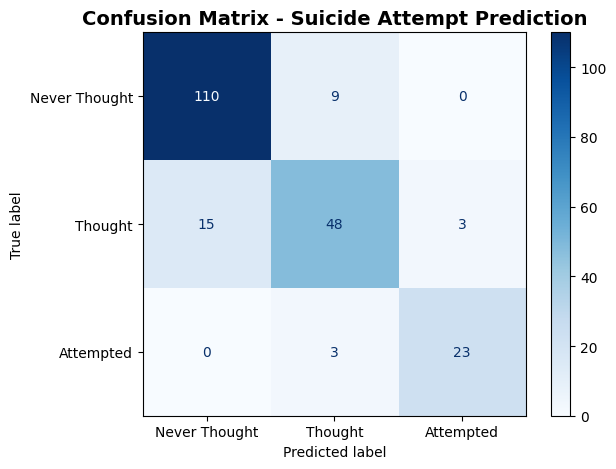

In [241]:
# ============ EVALUATE MODEL ============

print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {acc:.4f}")
target_names=['Never Thought', 'Thought', 'Attempted']

# Classification Report (shows metrics for each class)
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=['Never Thought', 'Thought', 'Attempted'],
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Suicide Attempt Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


#### EXAMPLE PREDICTIONS WITH PROBABILITIES

In [242]:
# ============ EXAMPLE PREDICTIONS WITH PROBABILITIES ============
print("\n" + "="*60)
print("EXAMPLE PREDICTIONS")
print("="*60)

# Show predictions for first 5 test samples
for i in range(min(5, len(X_test))):
    actual_class = ['Never Thought', 'Thought', 'Attempted'][y_test.iloc[i]]
    predicted_class = ['Never Thought', 'Thought', 'Attempted'][y_pred[i]]
    probs = y_pred_proba[i]
    
    print(f"\nSample {i+1}:")
    print(f"  Actual: {actual_class}")
    print(f"  Predicted: {predicted_class}")
    print(f"  Probabilities:")
    print(f"    - Never Thought: {probs[0]:.4f}")
    print(f"    - Thought: {probs[1]:.4f}")
    print(f"    - Attempted: {probs[2]:.4f}")
    print(f"  Confidence: {max(probs):.4f}")


EXAMPLE PREDICTIONS

Sample 1:
  Actual: Never Thought
  Predicted: Thought
  Probabilities:
    - Never Thought: 0.3000
    - Thought: 0.6900
    - Attempted: 0.0100
  Confidence: 0.6900

Sample 2:
  Actual: Thought
  Predicted: Thought
  Probabilities:
    - Never Thought: 0.3137
    - Thought: 0.6663
    - Attempted: 0.0200
  Confidence: 0.6663

Sample 3:
  Actual: Never Thought
  Predicted: Never Thought
  Probabilities:
    - Never Thought: 0.9200
    - Thought: 0.0800
    - Attempted: 0.0000
  Confidence: 0.9200

Sample 4:
  Actual: Attempted
  Predicted: Attempted
  Probabilities:
    - Never Thought: 0.0000
    - Thought: 0.0800
    - Attempted: 0.9200
  Confidence: 0.9200

Sample 5:
  Actual: Never Thought
  Predicted: Never Thought
  Probabilities:
    - Never Thought: 0.8900
    - Thought: 0.1100
    - Attempted: 0.0000
  Confidence: 0.8900
